In [1]:
import logging
import os
import gc

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from data.data_preparer import DataPreparer
from src.data.data_reader import DataReader
from src.predictor.multilayer_perceptron import MultiLayerPerceptronPredictor
from tools.RestaurantReviewsDataset import RestaurantReviewsDataset
from tools.config_parser import ConfigParser
from tools.profiles_manager import ProfilesManager

logging.basicConfig(level=logging.INFO)

while str(os.getcwd())[-3:] != 'src':  # Execute from src-directory root
    os.chdir('..')

In [2]:
businesses, reviews, tips, users = DataReader().read_data(part=5, total_parts=10)

In [3]:
def load_model(model_path: os.PathLike, businesses_f, reviews_f, tips_f, users_f):
    # Dummy model just to get the user profiles and business profiles
    user_profiles_location_f, business_profiles_location_f = MultiLayerPerceptronPredictor.get_profile_names(model_path)
    print(user_profiles_location_f)
    print(business_profiles_location_f)

    # Load appropriate data
    user_profiles_f = ProfilesManager().get_user_profiles(user_profiles_location_f)
    business_profiles_f = None if business_profiles_location_f in {"None", "", "none", None} else ProfilesManager().get_business_profiles(
        business_profiles_location_f)

    train_test_data_f = DataPreparer.get_train_test_validate(businesses_f, reviews_f, tips_f, users_f, user_profiles_f, business_profiles_f)

    # Create valid trained model
    trained_model = MultiLayerPerceptronPredictor(input_size=train_test_data_f[0].columns.size, output_size=1)
    trained_optimizer = optim.Adam(trained_model.parameters(), lr=0.002)
    trained_model.load(trained_optimizer, model_path)

    return trained_model, trained_optimizer, train_test_data_f

def find_worst_model_with_index(model_list) -> tuple[float, int]:
    highest_loss = max([model_f[1] for model_f in model_list])
    corresponding_index = [i for i, model_f in enumerate(model_list) if model_f[1] == highest_loss][0]
    return highest_loss, corresponding_index


def get_all_models_with_loss():
    models_dir = list(os.scandir(ConfigParser().get_value("predictor_model", "model_dir")))
    models_with_loss_f = []
    for _ in range(min(len(models_dir), 5)):
        models_with_loss_f.append((None, 99))
    for dir_entry in tqdm(models_dir, desc="Loading in models"):
        model_path = dir_entry.path
        model_f, _, train_test_data_f = load_model(model_path, businesses, reviews, tips, users)

        highest_loss, highest_index = find_worst_model_with_index(models_with_loss_f)
        current_loss = min(model_f.loss_history)
        if current_loss < highest_loss:
            models_with_loss_f[highest_index] = (model_f, current_loss, train_test_data_f)
    models_with_loss_f = sorted(models_with_loss_f, key=lambda data: data[1])
    return models_with_loss_f

In [4]:
models_with_loss = get_all_models_with_loss()
model: nn.Module = models_with_loss[0][0]

results = []

for model, _, train_test_data in models_with_loss:
    logging.info(f"Testing model with User Profiles: {model.user_profiles_location} and Business Profiles: {model.business_profiles_location}")
    model.eval()  # Prepare layers of model for evaluation
    with torch.no_grad():
        testX, testY = train_test_data[1], train_test_data[3]

        testX = testX.head(500)
        testY = testY.head(500)

        dl = RestaurantReviewsDataset(testX.to_numpy(), testY.to_numpy())
        test_loader = DataLoader(dl, batch_size=500)
        for x, y in test_loader:
            # Prepare data
            x, y = DataPreparer.get_tensor_for_ml(x, y)
            # Compute predictions and loss

            predictions = model(x)
            predictions = predictions.cpu().detach().numpy().squeeze().transpose()
            y = y.cpu().detach().numpy().squeeze().transpose()
            result = pd.DataFrame(data=[predictions, y]).transpose()
            result.columns = ['predicted', 'actual']
            result['predicted'] = result['predicted'].transform(lambda x: round(x * 4 + 1))
            result['actual'] = result['actual'].transform(lambda x: int(x * 4 + 1))
            result['difference'] = abs(result['predicted'] - result['actual'])
            results.append(result)

Loading in models:   0%|          | 0/1 [00:00<?, ?it/s]

BASIC_USER_PROFILES_400_no_sentiment.parquet
business_profile_approx_50_top10.parquet


INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-28_12h28__BASIC_USER_PROFILES_400_no_sentiment_business_profile_approx_50_top10.pt.
INFO:root:Testing model with User Profiles: BASIC_USER_PROFILES_400_no_sentiment.parquet and Business Profiles: business_profile_approx_50_top10.parquet


Histogram of differences between prediction and actual:
Models used: BASIC_USER_PROFILES_400_no_sentiment.parquet  |  business_profile_approx_50_top10.parquet


,predicted,actual,difference
0,5,5,0
1,4,5,1
2,4,2,2
3,3,2,1
4,3,1,2
...,...,...,...
495,3,2,1
496,2,1,1
497,1,1,0
498,3,5,2


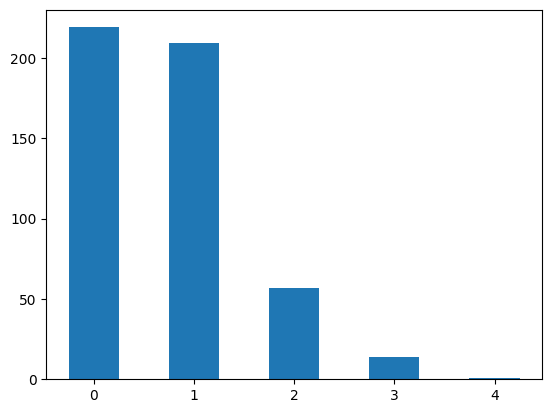

In [5]:
index = 0
result = results[index]
print("Histogram of differences between prediction and actual:")
print(f"Models used: {models_with_loss[index][0].user_profiles_location}  |  {models_with_loss[index][0].business_profiles_location}")
plt.hist(result['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5)
result

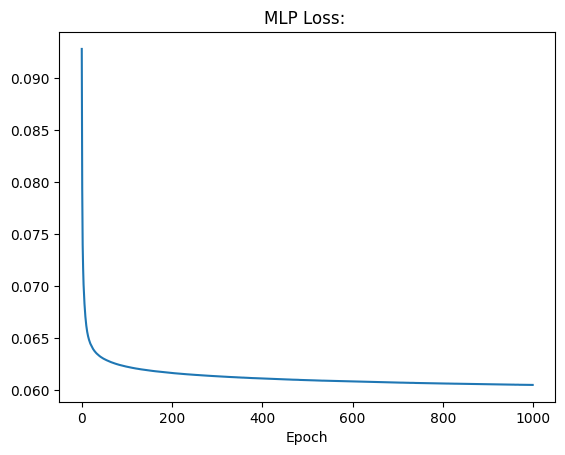

In [6]:
model.plot_loss_progress()[0]